In [18]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

import os
import pickle
import numpy as np

from skimage import io

from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
np.random.seed(0)
torch.manual_seed(0)

data = "parts_data"
batch_size = 64
workers = 4
distributed = False

# Data loading code
train_dir = os.path.join(data, 'train')
val_dir = os.path.join(data, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Ref: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
inv_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Ref: https://pytorch.org/docs/stable/torchvision/transforms.html

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

if distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
else:
    train_sampler = None

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=(train_sampler is None),
        num_workers=workers, pin_memory=True, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_dir, transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=True)

# input_dim = io.imread(train_dataset.imgs[0][0]).transpose(2,0,1).shape
# nw_input_dim = (batch_size,) + input_dim

input_dim = (3, ) + io.imread(train_dataset.imgs[0][0]).shape
input_dim

(3, 128, 128)

torch.Size([64, 3, 128, 128])


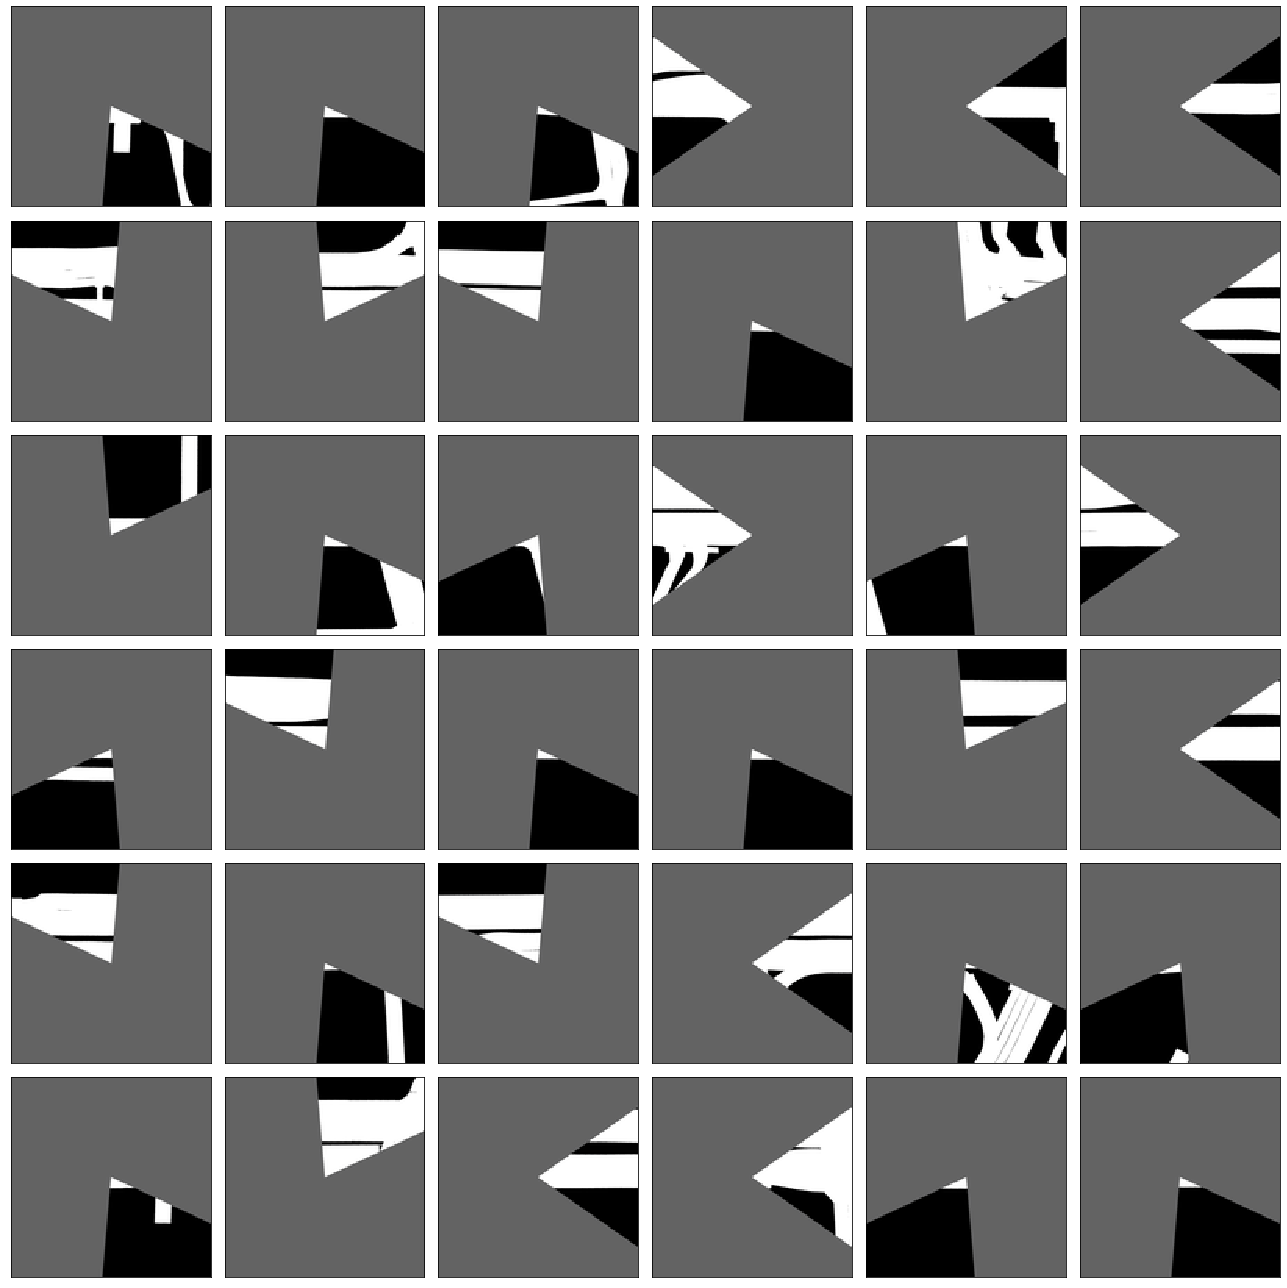

In [6]:
X, y = iter(train_loader).next()
print(X.shape)
plt.figure(figsize=(18,18))
for i in range(len(X)):
    if i <= 35:
        plt.subplot(6,6,i+1)
        plt.imshow(torch.clamp(inv_normalize(X[i]), 0, 1).permute(1,2,0))
        plt.xticks([]), plt.yticks([])
plt.tight_layout()

In [7]:
import ConvAE_AutoConf as ConvAE

feature_maps = 96
depth = 4
pooling_freq = 1e100 # large number to disable pooling layers
batch_norm_freq = 2
strided_conv_freq = 2
strided_conv_feature_maps = 8
code_size = 8

CONV_ENC_BLOCK = [("conv1", feature_maps), ("relu1", None)]
CONV_ENC_LAYERS = ConvAE.create_network(
    CONV_ENC_BLOCK, depth, 
    pooling_freq=pooling_freq,
    strided_conv_freq=strided_conv_freq, 
    strided_conv_channels=strided_conv_feature_maps,
    batch_norm_freq=batch_norm_freq)

CONV_ENC_NW = CONV_ENC_LAYERS + [("flatten1", None), ("linear1", 1024), ("relu1", None), ("linear1", 256)]
model = ConvAE.ConvAE(input_dim, enc_config=CONV_ENC_NW, store_activations=False)
# print("Encoder Nw Spec:")
# CONV_ENC_NW
print(model)

ConvAE(
  (encoder): ModuleList(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Reshape()
    (13): Linear(in_features=8192, out_features=1024, bias=True)
    (14): ReLU()
    (15): Linear(in_features=1024, out_features=256, bias=True)
  )
  (decoder): ModuleList(
    (0): Lin

In [8]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [9]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class DeFlatten(nn.Module):
    def __init__(self, *args):
        super(DeFlatten, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [28]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
#             nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
#             nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             Flatten(),
#             nn.Linear(in_features=8192, out_features=1024, bias=True),
#             nn.ReLU(),
#             nn.Linear(in_features=1024, out_features=256, bias=True)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=256, out_features=1024, bias=True),
#             nn.ReLU(),
#             nn.Linear(in_features=1024, out_features=8192, bias=True),
#             DeFlatten(-1, 8, 32, 32),
#             nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
#             nn.ReLU(),
#             nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#             nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
#             nn.ReLU(),
#             nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#             nn.ReLU(),
#             nn.ConvTranspose2d(96, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x
    
# model = Autoencoder().to(device)
# criterion = nn.MSELoss()

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(8, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.Conv2d(96, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            Flatten(),
            nn.Linear(in_features=8192, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=64, bias=True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=1024, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=8192, bias=True),
            DeFlatten(-1, 8, 32, 32),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ConvTranspose2d(8, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding = (1, 1), dilation = (1,1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )

    def forward(self, x):
        x = self.encoder(x)
        noise = Variable(torch.randn(x.size()) * 0.3)
        noise = noise.to(device)
        x = self.decoder(x + noise)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [29]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [30]:
from IPython.display import clear_output

num_epochs = 50
dataset_len = len(train_loader.dataset)
val_dataset_len = len(val_loader.dataset)
validation_losses = []
training_losses = []
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    total = 0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # ===================forward=====================
        output = model(img) 
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        clear_output(wait=True)
        total += len(data[0])     
        if len(validation_losses) == 0:
            print(f'epoch [{epoch + 1}/{num_epochs}], data trained:{100 * total / dataset_len :.3f}%, training loss:{loss.item():.4f}')
        else:
            print(f'epoch [{epoch + 1}/{num_epochs}], data trained:{100 * total / dataset_len :.3f}%, training loss:{loss.item():.4f}, validation loss (prev epoch):{validation_losses[-1]}')
    
#     with torch.no_grad():
#         total_vloss = 0
#         for val_data in val_loader:
#             vimg, _ = val_data
#             vimg = vimg.to(device)
#             voutput = model(vimg)
#             vloss = criterion(voutput, vimg.data)
#             total_vloss += vloss
#         validation_losses.append(total_vloss)
        
#     with torch.no_grad():
#         total_tloss = 0
#         for train_data in train_loader:
#             timg, _ = train_data
#             timg = timg.to(device)
#             toutput = model(timg)
#             tloss = criterion(toutput, timg.data)
#             total_tloss += tloss
#         training_losses.append(total_tloss)

    if (epoch + 1) % 10 == 0:
        torch.save(model, 'Models/ae_latent_noise_gpu_model_b64_w2_e'+ str(epoch + 1) +'.pt')
        model.to(torch.device('cpu'))
        torch.save(model, 'Models/ae_latent_noise_cpu_model_b64_w2_e'+ str(epoch + 1) +'.pt')
        model.to(device)        

KeyboardInterrupt: 

In [27]:
with open('gpu_training_losses.pkl', 'wb') as f:
    pickle.dump(training_losses, f)
    
with open('cpu_training_losses.pkl', 'wb') as f:
    training_losses.to(torch.device('cpu'))
    pickle.dump(training_losses, f)

/home/prs392/.conda/envs/pytorch/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


AttributeError: 'list' object has no attribute 'to'

In [ ]:
with open('gpu_validation_losses.pkl', 'wb') as f:
    pickle.dump(validation_losses, f)

with open('gpu_validation_losses.pkl', 'wb') as f:
    validation_losses.to(torch.device('cpu'))
    pickle.dump(validation_losses, f)

In [ ]:
import pickle
import os

if os.path.getsize('validation_losses.pkl') > 0:
    with open('validation_losses.pkl', 'rb') as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        validation_losses = unpickler.load()
validation_losses

In [ ]:
from torchvision import utils
def get_results_img(x, x_prime, nrow=8, padding=5):
        
    return utils.make_grid(
        torch.stack((x, x_prime), dim=1).view(-1, *(3, 128, 128)),
        nrow=nrow, padding=padding).permute(1,2,0)

In [ ]:
X, y = iter(train_loader).next()
X = X.to(device)
out = model(X)

out_normalized = torch.clamp(
    get_results_img(torch.stack([inv_normalize(img.detach()) for img in X]), 
                                       torch.stack([inv_normalize(img.detach()) for img in out])), 0, 1)

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(out_normalized.cpu().detach())

In [ ]:
X, y = iter(val_loader).next()
X = X.to(device)
out = model(X)

out_normalized = torch.clamp(
    get_results_img(torch.stack([inv_normalize(img.detach()) for img in X]), 
                                       torch.stack([inv_normalize(img.detach()) for img in out])), 0, 1)

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(out_normalized.cpu().detach())

In [ ]:
# torch.save(model, 'model_b64_w2_e20.pt')

In [ ]:
# model2 = torch.load('model_b64_w2_e20.pt')

# model2.to(device)

In [ ]:
# X, y = iter(val_loader).next()
# X = X.to(device)
# out = model2(X)

# out_normalized = torch.clamp(
#     get_results_img(torch.stack([inv_normalize(img.detach()) for img in X]), 
#                                        torch.stack([inv_normalize(img.detach()) for img in out])), 0, 1)

In [ ]:
# plt.figure(figsize=(18,18))
# plt.imshow(out_normalized.cpu().detach())